In [2]:
import torch
from torch_geometric.data import Data

# Load the cora dataset
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='dataset/cora', name='Cora')
data = dataset[0]

# Print the dataset
print(data)
print(data.keys)
print(data['x'])
print(data['edge_index'])
print(data['train_mask'])
print(data['val_mask'])
print(data['test_mask'])

# Visualize the dataset
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
colors = data.y.numpy()

plt.figure(figsize=(15, 15))
# nx.draw(G, pos=nx.spring_layout(G, seed=42, k=1/5, iterations=500), node_color=colors, cmap="Set2", node_size=5, linewidths=1)
plt.show()



Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
<bound method BaseData.keys of Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])>
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])
tensor([ True,  True,  True,  ..., False, False, False])
tensor([False, False, False,  ..., False, False, False])
tensor([False, False, False,  ...,  True,  True,  True])


<Figure size 1500x1500 with 0 Axes>

Epoch: 000, Loss: 0.0108, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.8120
Epoch: 010, Loss: 0.0135, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.8010
Epoch: 020, Loss: 0.0170, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7960
Epoch: 030, Loss: 0.0296, Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8140
Epoch: 040, Loss: 0.0100, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.8010
Epoch: 050, Loss: 0.0084, Train Acc: 1.0000, Val Acc: 0.7580, Test Acc: 0.8080
Epoch: 060, Loss: 0.0177, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.8030
Epoch: 070, Loss: 0.0285, Train Acc: 1.0000, Val Acc: 0.7620, Test Acc: 0.7990
Epoch: 080, Loss: 0.0246, Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.7990
Epoch: 090, Loss: 0.0154, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.8000
Epoch: 100, Loss: 0.0150, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.8020
Epoch: 110, Loss: 0.0245, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.8120
Epoch: 120, Loss: 0.0310, Train Acc: 1.0000, Val Acc

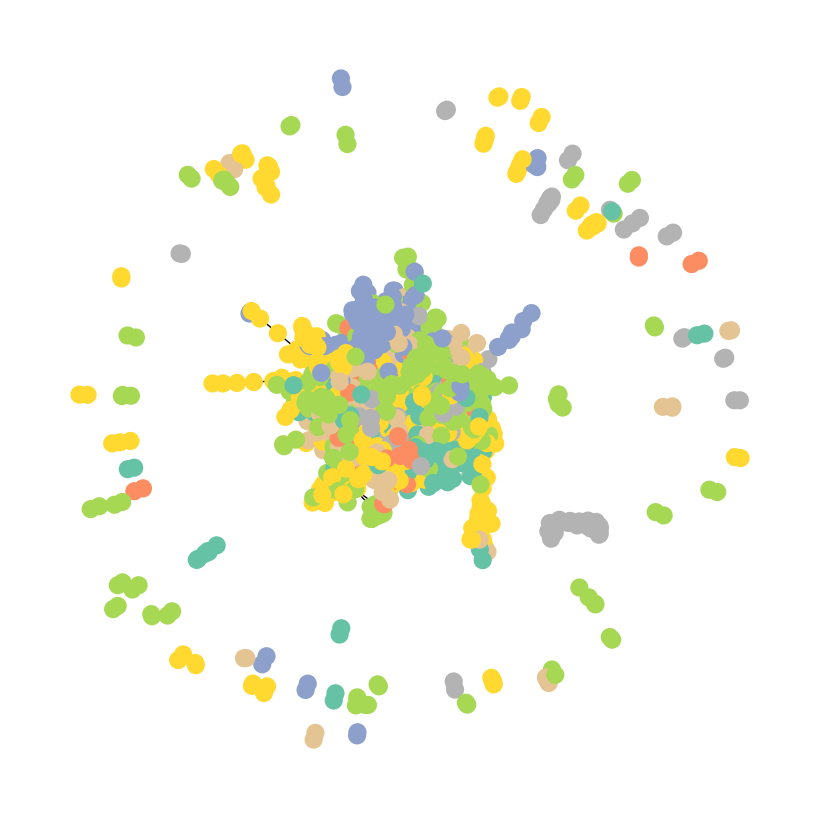

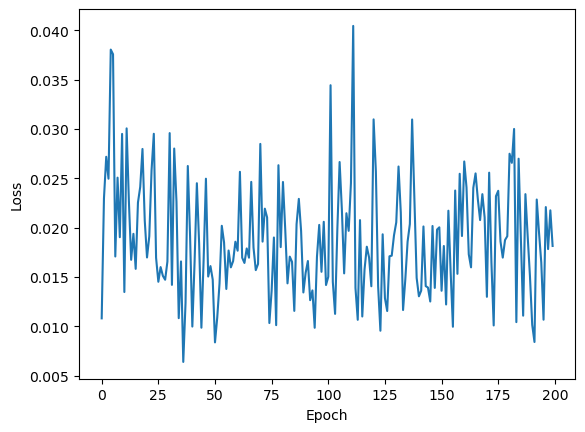

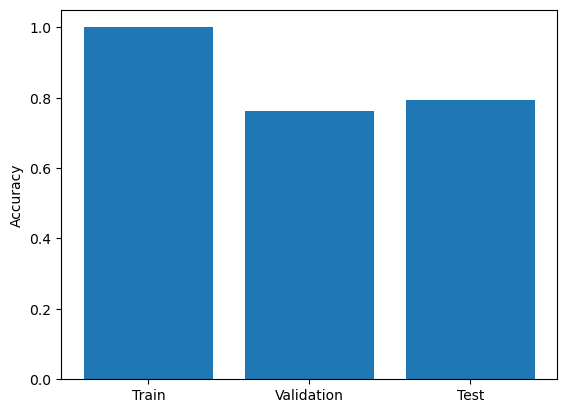

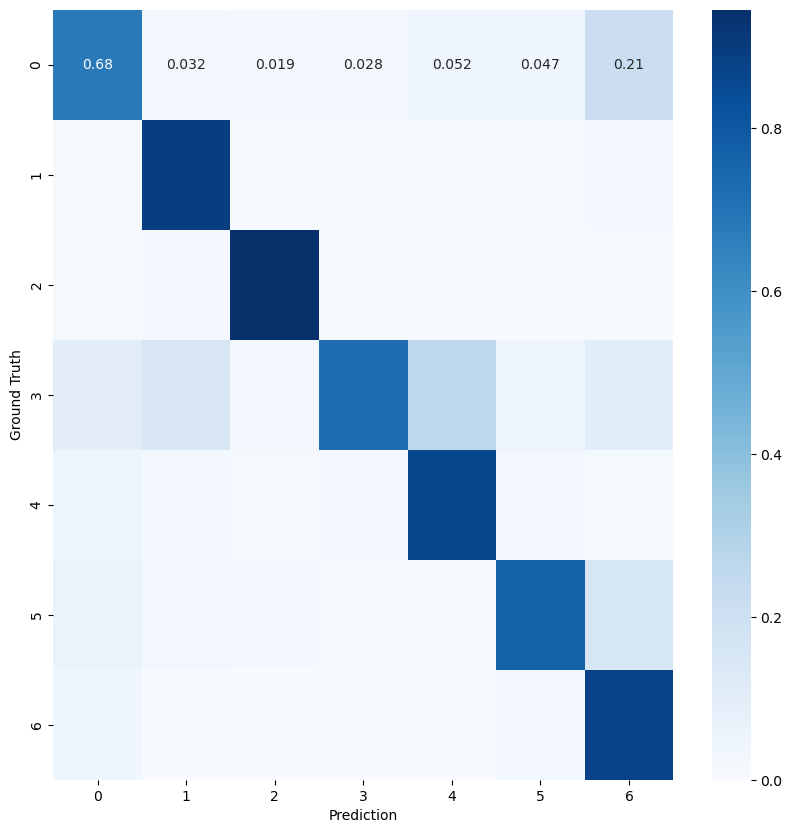

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Definiere ein einfaches GCN-Modell
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Erstelle das Modell, den Optimierer und den Verlust
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = []

# Load the model if it exists
import os
if os.path.exists('gcn.pth'):
    model.load_state_dict(torch.load('gcn.pth'))

# Definiere die Trainingsschleife
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Definiere die Evaluationsmethode
def test():
    model.eval()
    logits, accs = model(data), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# Trainiere das Modell
for epoch in range(200):
    loss = train()
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
        
# Save the model
torch.save(model.state_dict(), 'gcn.pth')

# Visualisiere die Ergebnisse
model.eval()
logits = model(data)
pred = logits.max(1)[1]

plt.figure(figsize=(8, 8))
nx.draw(G, pos=nx.spring_layout(G, seed=42), node_color=pred.numpy(), cmap="Set2", node_size=50, linewidths=6)
plt.show()

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the accuracy
train_acc, val_acc, test_acc = test()
plt.bar(['Train', 'Validation', 'Test'], [train_acc, val_acc, test_acc])
plt.ylabel('Accuracy')
plt.show()

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

confusion = confusion_matrix(data.y.numpy(), pred.numpy())
confusion = confusion / confusion.sum(axis=1)
# dataset is a Planetoid dataset
labels = dataset[0].y.unique().numpy()
df_cm = pd.DataFrame(confusion, index=labels, columns=labels)

plt.figure(figsize=(10, 10))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

